In [1]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)
#need a fork

# Assignment 3 - Basic Predictions and Regression

## Questions

### Part 1 - Election Prediction

Suppose you are looking at an election in a fictional province. There are 7 total elctoral districts, and the winner in each district is determined by a first-past-the-post system (what we have in Canada - the most votes wins, regardless of share). There are two parties - the Purples and the Yellows. Whoever controls the most seats will be the ruling party - so in our 2 party scenario, the party who wins 4 or more of the districts will govern. There is an election every year, they love voting. 

Recent polling indicating the expected vote share in each district is shown in the "dist_polls" table below. These values are a composite of several polls that the experts have combined and weighted. The "Purple" values show the expected vote share of the Purple party, along with the variance of that expectation and the number of polls that were combined to get that result.  

As well, research has shown that the vote distribution is impacted by voter turnout. In general, the more people vote, the more the vote split shifts towards the Yellow party. We have data on past elections and the results, we expect that the turnout will be in line with the past elections - or more specifically, we have no reason to expect it to differ. This impact is measured in the table in code below - that table shows the voter turnout, in a percentage, as well as the change in the Yellow party's vote share (also in percentage) as compared to the polling averages. For example, if one row showed "52" and ".8", that would mean that voter turnout was 52%, and the Yellow party got .8% higher of a vote share than the polling showed. 

<b>What is the probability that the Purple Party controls the government after the election?</b>

<b>Note:</b> the errors and confidence intervals are not totally trivial. As part of the written answer, offer an evaluation of your confidence in the prediction, and why you think that. This is not a question with one specific error, your estimation will have some expected errors, somewhere. You may not have the tools to calculate it all the way through, that's fine. 

### Question 1 - Your Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li>
<li>
<li>
<li> <b> What do you think about the error/accuracy:</b>
</ul>

##### Setup Poll Data

The dataframe "dist_polls" contains all of the polls for each seat. Each value is expressed as expected vote share (as a ratio) for the <b>Purple</b> party. The Yellow party can be safely assumed to get the rest of the votes. 

In [2]:
# Please don't edit this part. 
# Setup polling data. 
districts = [1,2,3,4,5,6,7]
dist_polls = pd.DataFrame(districts, columns={"district"})

dist_polls["Poll_1"] = [.55, .49, .51, .6, .41, .46, .54]
dist_polls["Poll_2"] = [.53, .51, .51, .62, .44, .48, .53]
dist_polls["Poll_3"] = [.51, .49, .53, .61, .42, .46, .52]
dist_polls["Poll_4"] = [.47, .48, .51, .54, .45, .45, .51]
dist_polls["Poll_5"] = [.61, .52, .49, .73, .44, .51, .53]
dist_polls["Poll_6"] = [.54, .45, .51, .61, .47, .52, .52]
dist_polls["Poll_7"] = [.55, .47, .5, .56, .47, .46, .56]
dist_polls["Poll_8"] = [.53, .49, .51, .55, .43, .49, .55]
dist_polls["Poll_9"] = [.57, .39, .52, .57, .53, .43, .53]


dist_polls.head()

,district,Poll_1,Poll_2,Poll_3,Poll_4,Poll_5,Poll_6,Poll_7,Poll_8,Poll_9
0,1,0.55,0.53,0.51,0.47,0.61,0.54,0.55,0.53,0.57
1,2,0.49,0.51,0.49,0.48,0.52,0.45,0.47,0.49,0.39
2,3,0.51,0.51,0.53,0.51,0.49,0.51,0.50,0.51,0.52
3,4,0.60,0.62,0.61,0.54,0.73,0.61,0.56,0.55,0.57
4,5,0.41,0.44,0.42,0.45,0.44,0.47,0.47,0.43,0.53


##### Setup Turnout Data

The dataframe "past_vte_table" shows the voter turnout, along with the impact on the votes counted for the <b>Yellow party</b>, all expressed as percentages. For example, if in one row the turnout is .45 and the Yellow_improvement is -.04, that means that 45% of the populace turned out to vote, and the Yellow party got 4% fewer votes than polling indicated. 

In [3]:
# Please don't edit this part. 
# Setup vote data. 
voter_turnout_history = [.53, .51, .48, .55, .54, .59, .49, .57, .56]
past_vote_table = pd.DataFrame(voter_turnout_history, columns={"voter_turn_percentage"})
past_vote_table["Yellow_improvement"] = [.012, .023, -.017, .031, .030, -.004, -.03, .042, .029]
past_vote_table["year"] = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
past_vote_table.head()

,voter_turn_percentage,Yellow_improvement,year
0,0.53,0.012,2013
1,0.51,0.023,2014
2,0.48,-0.017,2015
3,0.55,0.031,2016
4,0.54,0.030,2017


## Start Your Work

### Part 1 - Election

In [4]:
def getSample(voteProb, n=1000):
    vote_list = []
    for i in range(n):
        vote_list.append(np.random.binomial(n=1, p=voteProb))
    return vote_list

In [5]:
def simulateDistrictElection(voteProb,times = 100):
    meanList = []
    for i in range(times):
        meanList.append(np.mean(getSample(voteProb, times)))
    muList = [voteProb] * times
    cdf = thinkstats2.Cdf(meanList) #Make a CDF of the means of the analytical dist's
    ci = cdf.Percentile(2.5), cdf.Percentile(97.5) #5th, 95th percentiles. 
    stderr = mean_squared_error(meanList, muList, squared=False)
    return meanList, stderr, cdf, ci


In [6]:
piv = dist_polls.T
piv = piv.drop(axis=0, index={"district"})
piv.head()

,0,1,2,3,4,5,6
Poll_1,0.55,0.49,0.51,0.60,0.41,0.46,0.54
Poll_2,0.53,0.51,0.51,0.62,0.44,0.48,0.53
Poll_3,0.51,0.49,0.53,0.61,0.42,0.46,0.52
Poll_4,0.47,0.48,0.51,0.54,0.45,0.45,0.51
Poll_5,0.61,0.52,0.49,0.73,0.44,0.51,0.53


In [7]:
def simulateAll(piv, yellowImprovement, trials = 1000):
    returnArray = []
    amountToWin = .5 + yellowImprovement
    for column in piv.columns:
        means, err, cdf, ci = simulateDistrictElection(piv[column].mean(), trials)
        purpWins = 0
        for i in range(len(means)):
            if means[i] > amountToWin:
                purpWins = purpWins + 1
        #add it to the return array
        returnArray.append([column + 1, means, err, cdf, ci, (purpWins/trials)])
    return returnArray

In [15]:
#Find the improvement for yellow if the voter turnout is 60%
x = np.array(past_vote_table["Yellow_improvement"]).reshape(-1,1)
y = np.array(past_vote_table["voter_turn_percentage"]).reshape(-1,1)

model = LinearRegression().fit(y, x)
pred = model.predict(np.array(0.60).reshape(-1,1))
yellowImprovement = pred[0][0]

In [27]:
results = simulateAll(piv, yellowImprovement)

In [29]:
numOfPurpWins = 0
for result in results:
    print("district",result[0], ": percent of scenarios where purple wins:%.1f%%" % (result[5] * 100))
    print("district", result[0], ": 95%% confidence that purple gets %.1f%% and %.1f%% percent of the vote" % (result[4][0]*100, result[4][1]*100))
    print("\n")


district 1 : percent of scenarios where purple wins:55.8%
district 1 : 95% confidence that purple gets 50.9% and 57.0% percent of the vote


district 2 : percent of scenarios where purple wins:0.0%
district 2 : 95% confidence that purple gets 44.4% and 50.6% percent of the vote


district 3 : percent of scenarios where purple wins:4.9%
district 3 : 95% confidence that purple gets 48.0% and 54.3% percent of the vote


district 4 : percent of scenarios where purple wins:100.0%
district 4 : 95% confidence that purple gets 56.7% and 63.0% percent of the vote


district 5 : percent of scenarios where purple wins:0.0%
district 5 : 95% confidence that purple gets 42.0% and 48.2% percent of the vote


district 6 : percent of scenarios where purple wins:0.0%
district 6 : 95% confidence that purple gets 44.2% and 50.4% percent of the vote


district 7 : percent of scenarios where purple wins:38.1%
district 7 : 95% confidence that purple gets 50.3% and 56.3% percent of the vote




In [24]:
# Do some stuff
# Voter turnout needs to be dealt with
# voteTurnoutstat, voteturnoutp = ss.ttest_ind(past_vote_table["voter_turn_percentage"], past_vote_table["Yellow_improvement"])
# voteturnoutp

#get means for each district based on the polls???????????????????????????
districtMeans = dist_polls.groupby(by="district", axis=0)
districtMeans.head()

,district,Poll_1,Poll_2,Poll_3,Poll_4,Poll_5,Poll_6,Poll_7,Poll_8,Poll_9
0,1,0.55,0.53,0.51,0.47,0.61,0.54,0.55,0.53,0.57
1,2,0.49,0.51,0.49,0.48,0.52,0.45,0.47,0.49,0.39
2,3,0.51,0.51,0.53,0.51,0.49,0.51,0.50,0.51,0.52
3,4,0.60,0.62,0.61,0.54,0.73,0.61,0.56,0.55,0.57
4,5,0.41,0.44,0.42,0.45,0.44,0.47,0.47,0.43,0.53
5,6,0.46,0.48,0.46,0.45,0.51,0.52,0.46,0.49,0.43
6,7,0.54,0.53,0.52,0.51,0.53,0.52,0.56,0.55,0.53


there is a signifcance between turnout and yellow__improve
take mean of past turnout, guess at improvement!?!?!

- we know teh probability of a voter (based on the polls) voting purple
- mean poll probabilities ?
- run estimation loops based on taht for each district
- if 4/7 vote purple they winx 
- get rmse
- get CI
- model the yellow improvement to make a pred for 60% turnout
- adjust based on voter turnout

what do we want to determine
simulate all 7 elections 
take the data we have about the distribution of voting
*find the probability of an idividual voting one way or another*


use a model to predict the turnout/improvement?


***Assume 60% turnout!***

<AxesSubplot:xlabel='voter_turn_percentage', ylabel='Yellow_improvement'>

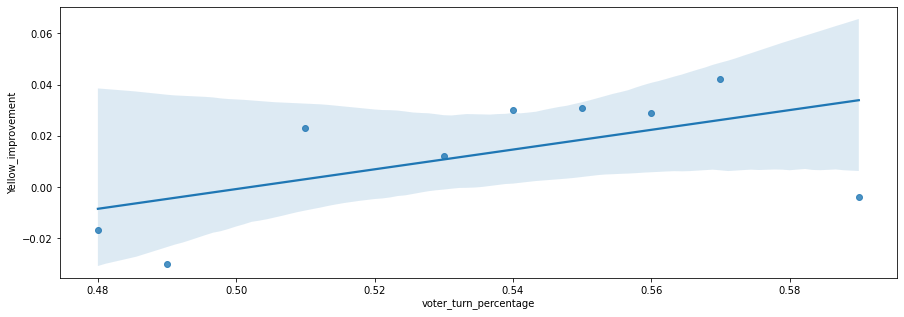

In [70]:
sns.regplot(x=past_vote_table["voter_turn_percentage"], y=past_vote_table["Yellow_improvement"])
# sns.regplot(x=past_vote_table["year"],y=past_vote_table["voter_turn_percentage"])

### Part 2 - Regression

<b>Use the data provided to try to predict the wage. </b>

The data is from FIFA rankings for players. You don't need to know anything about soccer or video games for this, so if these values are meaningless to you, just treat them as numbers and you'll be fine. All of the features are rankings are evaluations of how good different soccar players are at different skills.

#### Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li>
<li>
<li>
</ul>

In [25]:
df = pd.read_csv("players_20_2.csv")
df.head()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,565000,88,95,70,92,88,97,93,94,92,...,94,48,40,94,94,75,96,33,37,26
1,405000,84,94,89,83,87,89,81,76,77,...,93,63,29,95,82,85,95,28,32,24
2,290000,87,87,62,87,87,96,88,87,81,...,84,51,36,87,90,90,94,27,26,29
3,125000,13,11,15,43,13,12,13,14,40,...,12,34,19,11,65,11,68,27,12,18
4,470000,81,84,61,89,83,95,83,79,83,...,80,54,41,87,89,88,91,34,27,22


- multivariant poly??
- log the wage?
-

In [36]:
# sns.pairplot(df)
# sns.histplot(df["wage_eur"])
# df["wage_eur"].describe()
#  df = df[df["wage_eur"] > 1000]
# df["wage_eur_log"] = np.log(df["wage_eur"])
df["wage_eur_log"].sample(10)

1823     2.220327
17728    2.028267
2048     2.329719
14541    2.028267
11620    2.115538
12424    2.180832
14983    2.028267
12247    2.028267
10295    2.028267
397      2.455537
Name: wage_eur_log, dtype: float64